In [1]:
%matplotlib inline


In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from scipy import stats

In [41]:
def regression (xnot,ynot,xxx,yyy):
    yval = [] 
    xval = [] 
    totdays = len(xxx) -2
    if totdays-xnot>3:
        for days in range(xnot,totdays):
            xval.append(xxx[days])
            if yyy[days]!=0:
                ystr = yyy[days]/ynot
                yval.append(np.log(ystr))
            else:
                yval.append(1)
        (slope, intercept, r, a, b)=stats.linregress(xval, yval)
    else:
        slope = 0
        r=0
    return slope,r*r

In [4]:
def cleaning (dirty,var_cln):
    for st in states.index:
        hold = dirty[st]
        for cnt in hold:
            new_var = var_cln+'I'
            hold[cnt].update({new_var:[0]})
            if len(hold[cnt][var_cln]) > 2:
                for x in np.arange(1,len(hold[cnt][var_cln])-1,1):
                    hold[cnt][new_var].append((hold[cnt][var_cln][x-1]+hold[cnt][var_cln][x]+hold[cnt][var_cln][x+1])/3)
                hold[cnt][new_var].append(hold[cnt][var_cln][x+1])


In [5]:
data = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv")
df = pd.DataFrame(data)
df.head()
dfar = df.loc[df['county']== 'New York City']
dfar.head()   

,date,county,state,fips,cases,deaths
416,2020-03-01,New York City,New York,NaN,1,0
448,2020-03-02,New York City,New York,NaN,1,0
482,2020-03-03,New York City,New York,NaN,2,0
518,2020-03-04,New York City,New York,NaN,2,0
565,2020-03-05,New York City,New York,NaN,4,0


In [6]:
df['date'] = pd.to_datetime(df['date'])
states = df['state'].value_counts()

In [7]:
#Build raw data dictionary for county derivitive vs days
exponential={}
for st in states.index:
    state = df.loc[df['state']==st]
    counties = state['county'].value_counts()
    exponential.update( {st : {}} )
    for cnt in counties.index:
        county = state.loc[(df['county'] == cnt)]
        yprev = 0
        exponential[st].update({cnt:{}})
        exponential[st][cnt].update( {'xval' : []})
        exponential[st][cnt].update({'delta' :[]})
        days=0
        for y,z in county.iterrows(): 
            ycur = z['cases']
            dif = ycur - yprev
            exponential[st][cnt]['delta'].append(dif)
            exponential[st][cnt]['xval'].append(days)
            days=days+1
            yprev = ycur
        
    

In [8]:
cleaning(exponential,'delta')
cleaning(exponential,'deltaI')
cleaning(exponential,'deltaII')
cleaning(exponential,'deltaIII')

In [34]:
#build raw data dictionary for county cases vs days
population={}
for st in states.index:
    state = df.loc[df['state']==st]
    counties = state['county'].value_counts()
    population.update( {st : {}} )
    for cnt in counties.index:
        county = state.loc[(df['county'] == cnt)]
        population[st].update({cnt:{}})
        population[st][cnt].update( {'xval' : []})
        population[st][cnt].update({'cases' :[]})
        days=0
        for y,z in county.iterrows(): 
            ycur = z['cases']
            population[st][cnt]['cases'].append(ycur)
            population[st][cnt]['xval'].append(days)
            days=days+1

In [35]:
cleaning(population, 'cases')   #data cleaning see box 4
cleaning(population, 'casesI')

In [43]:
#code for building a dictionary to be passed into a dataframe
direct_tau = {'State':[],'County':[],'First Doubling':[], 'Current Total':[],
              'Inv Tau':[],'Tau':[],'R Squared':[],'Days In':[], 'ID':[]}
for st in states.index:
    test = population[st]  #pass each state dictionary into holding dictionary
    for cnt in test:
        day=0
        test2 = test[cnt]  #pass each county dictionary into holding dictionary
        for x in np.arange(1, len(test2['casesII']),1):  #iterate through days to test for thresh hold
            if test2['cases'][x]>4:
                day = x
                start =test2['cases'][x]
                invtau,rr = regression(day,start,test2['xval'],test2['casesII']) #regression analysis(see box 3)
                direct_tau['State'].append(st)
                direct_tau['County'].append(cnt)
                direct_tau['First Doubling'].append(day)
                direct_tau['Current Total'].append(test2['cases'][len(test2['cases'])-1])
                direct_tau['Inv Tau'].append(invtau)
                direct_tau['Days In'].append(len(test2['cases'])-1)
                if invtau != 0:
                    direct_tau['Tau'].append(1/invtau)
                else:
                    direct_tau['Tau'].append(0)
                direct_tau['R Squared'].append(rr)
                fips_hold=df.loc[(df['county']==cnt)&(df['state']==st)]
                fips_hold=fips_hold.reset_index()
                direct_tau['ID'].append(fips_hold['fips'][0])
                break

In [44]:
direct_df=pd.DataFrame(direct_tau)
direct_df = direct_df.sort_values('Inv Tau', ascending =False)
direct_df.to_csv('Hospitals/output_data/county_metrics')
direct_df.head()

,State,County,First Doubling,Current Total,Inv Tau,Tau,R Squared,Days In,ID
1211,Iowa,Louisa,2,70,0.486420,2.055836,0.983800,8,19115.0
42,Georgia,Randolph,11,103,0.380081,2.631020,0.988691,22,13243.0
1799,Maine,Waldo,13,27,0.351932,2.841459,0.989152,18,23027.0
1024,Illinois,Adams,17,25,0.339437,2.946052,0.999164,22,17001.0
704,Ohio,Washington,12,36,0.320155,3.123488,0.954020,19,39167.0


In [45]:
NC_direct = direct_df.loc[direct_df['State']=='North Carolina']
NC_direct.to_csv('hospitals/output_data/NCcounty_metrics')
NC_direct.head()

,State,County,First Doubling,Current Total,Inv Tau,Tau,R Squared,Days In,ID
412,North Carolina,Wayne,20,69,0.280213,3.568715,0.991795,29,37191.0
444,North Carolina,Granville,7,88,0.267412,3.739542,0.983824,20,37077.0
467,North Carolina,Edgecombe,7,22,0.247070,4.047428,0.995329,14,37065.0
453,North Carolina,Burke,5,61,0.229702,4.353457,0.997098,17,37023.0
470,North Carolina,Columbus,7,31,0.227907,4.387753,0.970806,13,37047.0


In [46]:
county_tau = {'State':[],'County':[],'First Doubling':[], 'Last Delta':[],
              'Inv Tau':[],'Tau':[],'R Squared':[],'ID':[]}
for st in states.index:
    test = exponential[st]
    for cnt in test:
        day=0
        test2 = test[cnt]
        for x in np.arange(1, len(test2['deltaIII']),1):
            if test2['deltaIII'][x]>4:
                day = x
                invtau,rr = regression(day,test2['deltaIII'][x],test2['xval'],test2['deltaIII']) 
                county_tau['State'].append(st)
                county_tau['County'].append(cnt)
                county_tau['First Doubling'].append(day)
                county_tau['Last Delta'].append(test2['delta'][len(test2['delta'])-1])
                county_tau['Inv Tau'].append(invtau)
                if invtau != 0:
                    county_tau['Tau'].append(1/invtau)
                else:
                    county_tau['Tau'].append(0)
                county_tau['R Squared'].append(rr)
                fips_hold=df.loc[(df['county']==cnt)&(df['state']==st)]
                fips_hold=fips_hold.reset_index()
                county_tau['ID'].append(fips_hold['fips'][0])
                break


KeyError: 'cases'

In [ ]:
deriv_df=pd.DataFrame(county_tau)
deriv_df=deriv_df.sort_values('Inv Tau', ascending =False)
deriv_df.to_csv('Hospitals/output_data/derivitivedata')
deriv_df.head()


In [ ]:
NC_deriv = deriv_df.loc[deriv_df['State']=='North Carolina']
NC_deriv.to_csv('Hospitals/output_data/NCderivitivedata')

(0, 10)

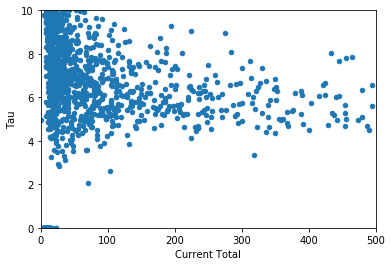

In [47]:
direct_df.plot('Current Total','Tau', kind ='scatter')
plt.xlim(0,500)
plt.ylim(0,10)

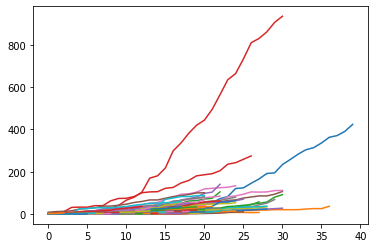

In [48]:
state = 'North Carolina'
test =population[state]
for x in test:
     if len(test[x]['cases']) >2:
            plt.plot(test[x]['xval'],test[x]['cases'])
plt.show()

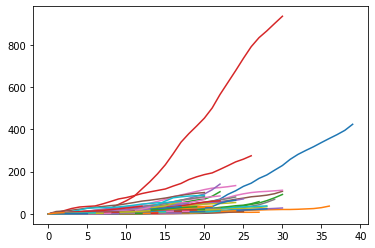

In [49]:
for x in test:
     if len(test[x]['cases']) >2:
            plt.plot(test[x]['xval'],test[x]['casesI'])
plt.show()

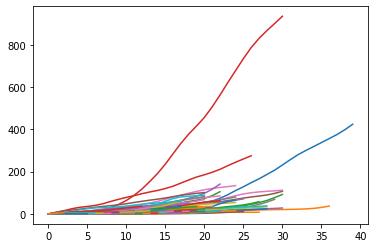

In [50]:
for x in test:
     if len(test[x]['cases']) >2:
            plt.plot(test[x]['xval'],test[x]['casesII'])
plt.show()

Wake County
              State County  First Doubling  Current Total   Inv Tau       Tau  \
405  North Carolina   Wake               6            424  0.149759  6.677382   

     R Squared  Days In       ID  
405    0.98246       39  37183.0  


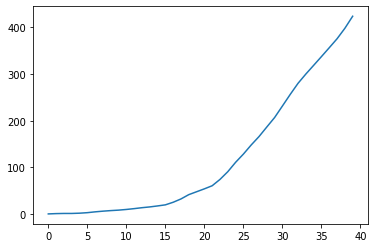

Chatham County
              State   County  First Doubling  Current Total   Inv Tau  \
406  North Carolina  Chatham              19             37  0.079426   

           Tau  R Squared  Days In       ID  
406  12.590413   0.895781       36  37037.0  


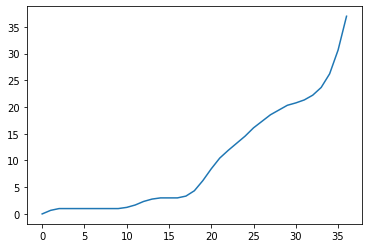

Johnston County
              State    County  First Doubling  Current Total   Inv Tau  \
407  North Carolina  Johnston              13             92  0.149432   

          Tau  R Squared  Days In       ID  
407  6.692027   0.992462       30  37101.0  


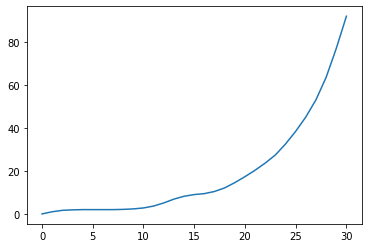

Mecklenburg County
              State       County  First Doubling  Current Total   Inv Tau  \
408  North Carolina  Mecklenburg               5            935  0.191957   

        Tau  R Squared  Days In       ID  
408  5.2095   0.899912       30  37119.0  


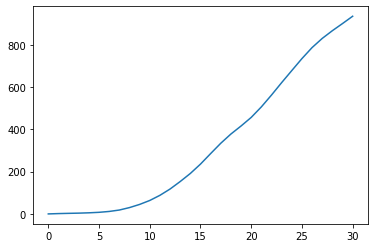

Onslow County
              State  County  First Doubling  Current Total   Inv Tau  \
409  North Carolina  Onslow              18             28  0.159643   

          Tau  R Squared  Days In       ID  
409  6.263963   0.985817       30  37133.0  


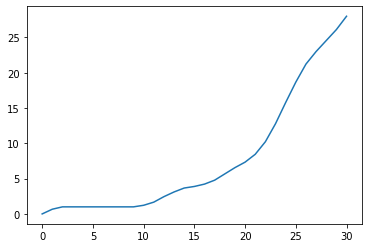

Cabarrus County
              State    County  First Doubling  Current Total   Inv Tau  \
410  North Carolina  Cabarrus              11            107  0.146638   

          Tau  R Squared  Days In       ID  
410  6.819524   0.925625       30  37025.0  


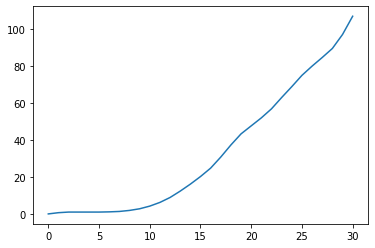

Forsyth County
              State   County  First Doubling  Current Total   Inv Tau  \
411  North Carolina  Forsyth               8            112  0.146216   

          Tau  R Squared  Days In       ID  
411  6.839199   0.984359       30  37067.0  


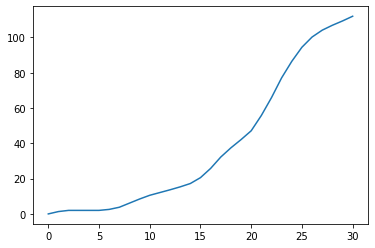

Wayne County
              State County  First Doubling  Current Total   Inv Tau       Tau  \
412  North Carolina  Wayne              20             69  0.280213  3.568715   

     R Squared  Days In       ID  
412   0.991795       29  37191.0  


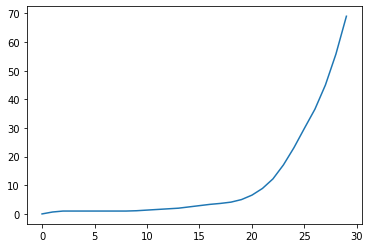

Brunswick County
              State     County  First Doubling  Current Total   Inv Tau  \
413  North Carolina  Brunswick               8             34  0.090598   

           Tau  R Squared  Days In       ID  
413  11.037793   0.961705       28  37019.0  


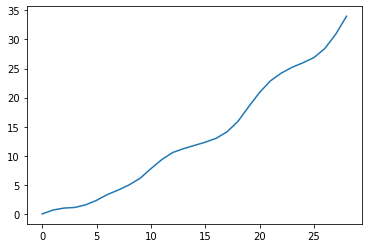

Harnett County
              State   County  First Doubling  Current Total   Inv Tau  \
414  North Carolina  Harnett               5             38  0.088351   

           Tau  R Squared  Days In       ID  
414  11.318494   0.995753       28  37085.0  


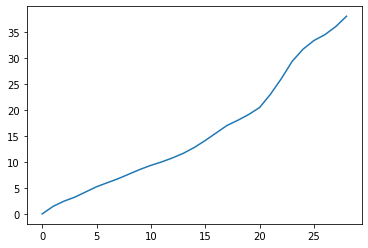

Craven County
              State  County  First Doubling  Current Total   Inv Tau  \
415  North Carolina  Craven              15             24  0.146988   

          Tau  R Squared  Days In       ID  
415  6.803297   0.971385       28  37049.0  


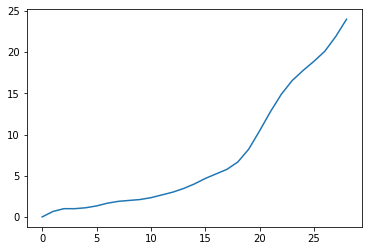

Watauga County
              State   County  First Doubling  Current Total   Inv Tau  \
416  North Carolina  Watauga              13              8  0.046439   

           Tau  R Squared  Days In       ID  
416  21.533808    0.93228       27  37189.0  


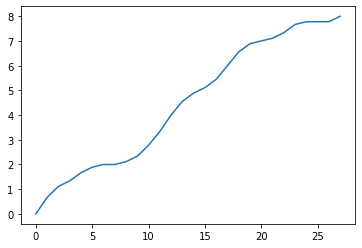

Wilson County
              State  County  First Doubling  Current Total   Inv Tau  \
417  North Carolina  Wilson              10             58  0.139743   

          Tau  R Squared  Days In       ID  
417  7.155994   0.994921       27  37195.0  


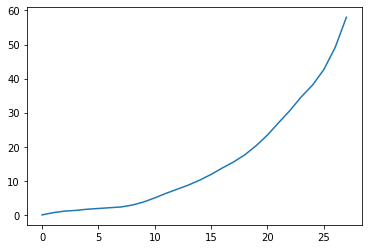

Durham County
              State  County  First Doubling  Current Total  Inv Tau       Tau  \
418  North Carolina  Durham               2            275  0.11135  8.980731   

     R Squared  Days In       ID  
418   0.949646       26  37063.0  


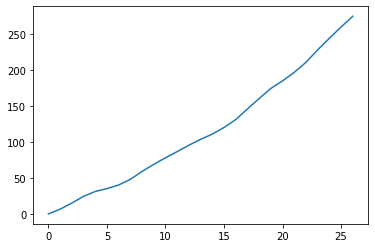

Iredell County
              State   County  First Doubling  Current Total   Inv Tau  \
419  North Carolina  Iredell               5             71  0.129875   

          Tau  R Squared  Days In       ID  
419  7.699737   0.965484       25  37097.0  


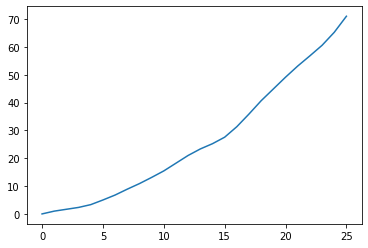

Sampson County
              State   County  First Doubling  Current Total  Inv Tau  Tau  \
420  North Carolina  Sampson              22             11      0.0  0.0   

     R Squared  Days In       ID  
420        0.0       25  37163.0  


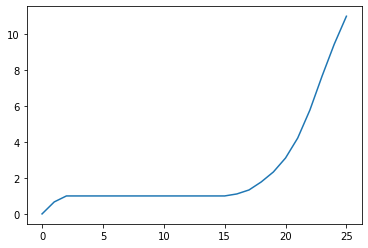

Guilford County
              State    County  First Doubling  Current Total   Inv Tau  \
421  North Carolina  Guilford               4            134  0.140254   

          Tau  R Squared  Days In       ID  
421  7.129912   0.965527       24  37081.0  


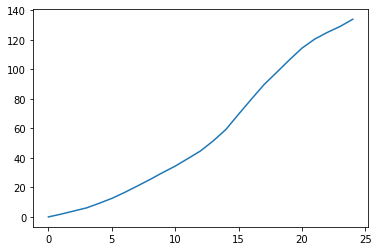

Gaston County
              State  County  First Doubling  Current Total   Inv Tau  \
422  North Carolina  Gaston               7             80  0.152064   

          Tau  R Squared  Days In       ID  
422  6.576193   0.918461       24  37071.0  


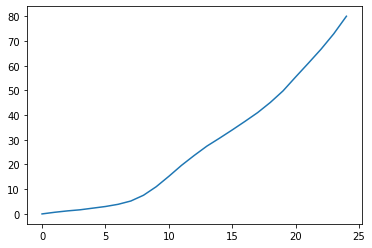

New Hanover County
              State       County  First Doubling  Current Total   Inv Tau  \
423  North Carolina  New Hanover               6             54  0.115798   

          Tau  R Squared  Days In       ID  
423  8.635754   0.906324       24  37129.0  


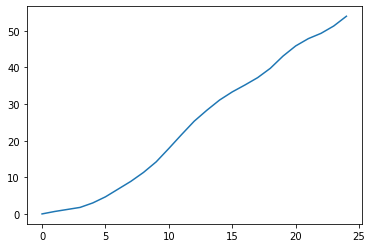

Hoke County
              State County  First Doubling  Current Total   Inv Tau       Tau  \
424  North Carolina   Hoke              15             18  0.102261  9.778907   

     R Squared  Days In       ID  
424   0.972567       24  37093.0  


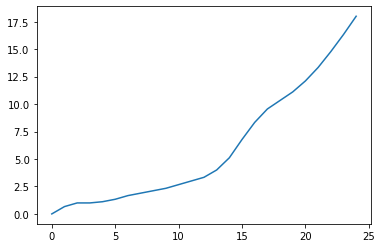

Moore County
              State County  First Doubling  Current Total   Inv Tau      Tau  \
425  North Carolina  Moore              11             65  0.175752  5.68982   

     R Squared  Days In       ID  
425   0.823403       24  37125.0  


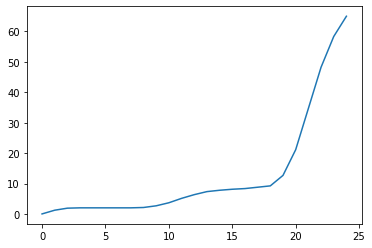

Lincoln County
              State   County  First Doubling  Current Total   Inv Tau  \
426  North Carolina  Lincoln              14             15  0.082205   

           Tau  R Squared  Days In       ID  
426  12.164677   0.924167       24  37109.0  


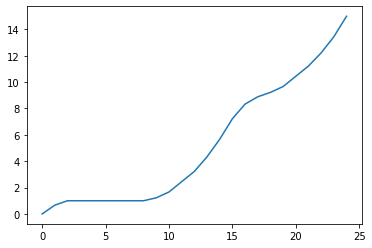

Rowan County
              State County  First Doubling  Current Total   Inv Tau       Tau  \
427  North Carolina  Rowan               4            105  0.169958  5.883792   

     R Squared  Days In       ID  
427   0.969465       22  37159.0  


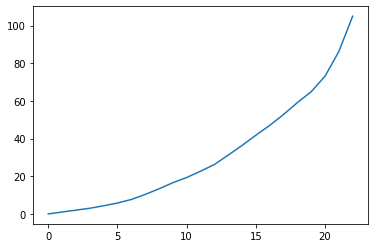

Pitt County
              State County  First Doubling  Current Total   Inv Tau       Tau  \
428  North Carolina   Pitt               4             62  0.143338  6.976524   

     R Squared  Days In       ID  
428   0.949732       22  37147.0  


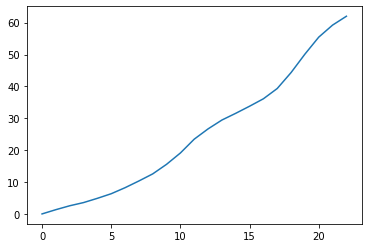

Orange County
              State  County  First Doubling  Current Total   Inv Tau  \
429  North Carolina  Orange               2            141  0.141286   

          Tau  R Squared  Days In       ID  
429  7.077837   0.946042       22  37135.0  


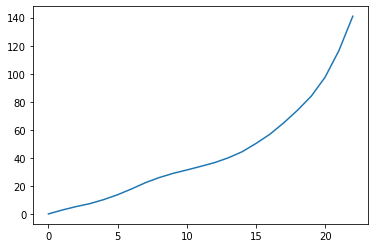

Pasquotank County
              State      County  First Doubling  Current Total   Inv Tau  \
430  North Carolina  Pasquotank              13             15  0.072001   

           Tau  R Squared  Days In       ID  
430  13.888735    0.97909       22  37139.0  


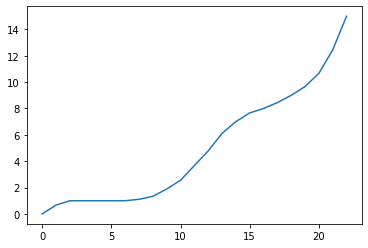

Davidson County
              State    County  First Doubling  Current Total   Inv Tau  \
431  North Carolina  Davidson               8             85  0.157996   

          Tau  R Squared  Days In       ID  
431  6.329261   0.958289       22  37057.0  


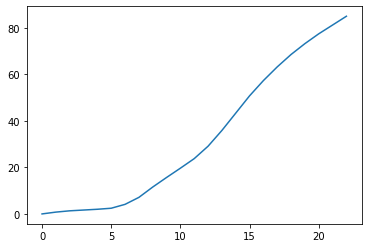

Franklin County
              State    County  First Doubling  Current Total   Inv Tau  \
432  North Carolina  Franklin               4             27  0.109799   

          Tau  R Squared  Days In       ID  
432  9.107554    0.96952       22  37069.0  


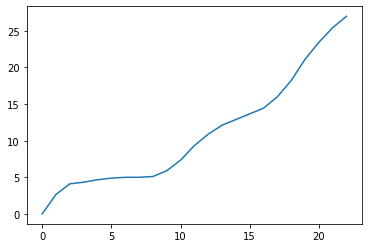

Carteret County
              State    County  First Doubling  Current Total   Inv Tau  \
433  North Carolina  Carteret               5             21  0.096835   

           Tau  R Squared  Days In       ID  
433  10.326865   0.935061       22  37031.0  


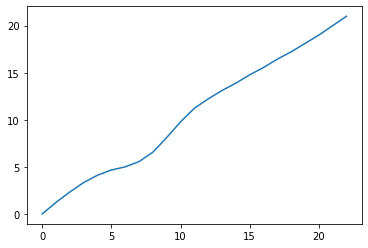

Stanly County
              State  County  First Doubling  Current Total   Inv Tau  \
434  North Carolina  Stanly               9             14  0.071707   

           Tau  R Squared  Days In       ID  
434  13.945689   0.981861       22  37167.0  


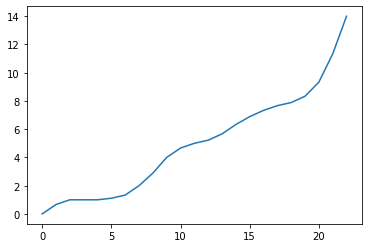

Catawba County
              State   County  First Doubling  Current Total  Inv Tau  \
435  North Carolina  Catawba               6             33  0.09105   

           Tau  R Squared  Days In       ID  
435  10.982924   0.947648       21  37035.0  


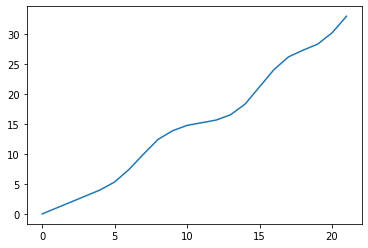

Buncombe County
              State    County  First Doubling  Current Total   Inv Tau  \
436  North Carolina  Buncombe               3             36  0.083235   

           Tau  R Squared  Days In       ID  
436  12.014185    0.87032       21  37021.0  


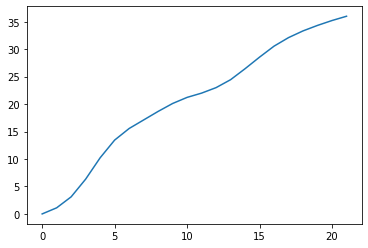

Davie County
              State County  First Doubling  Current Total   Inv Tau  \
437  North Carolina  Davie               7             21  0.089619   

           Tau  R Squared  Days In       ID  
437  11.158347   0.960948       20  37059.0  


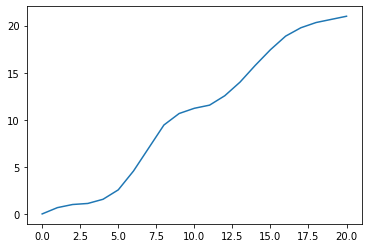

Scotland County
              State    County  First Doubling  Current Total  Inv Tau  Tau  \
438  North Carolina  Scotland              20              9      0.0  0.0   

     R Squared  Days In       ID  
438        0.0       20  37165.0  


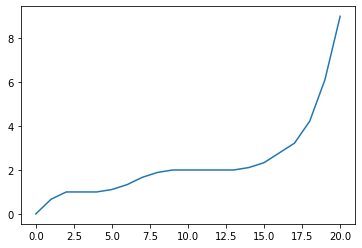

Robeson County
              State   County  First Doubling  Current Total   Inv Tau  \
439  North Carolina  Robeson              14              7  0.100764   

          Tau  R Squared  Days In       ID  
439  9.924174   0.974343       20  37155.0  


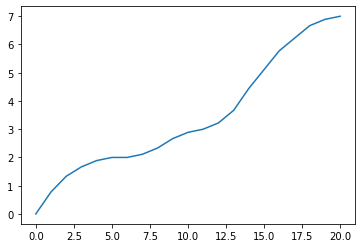

Union County
              State County  First Doubling  Current Total   Inv Tau       Tau  \
440  North Carolina  Union               1            101  0.122528  8.161432   

     R Squared  Days In       ID  
440   0.930492       20  37179.0  


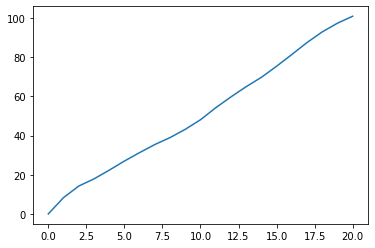

Henderson County
              State     County  First Doubling  Current Total   Inv Tau  \
441  North Carolina  Henderson               5             68  0.160789   

          Tau  R Squared  Days In       ID  
441  6.219337    0.96768       20  37089.0  


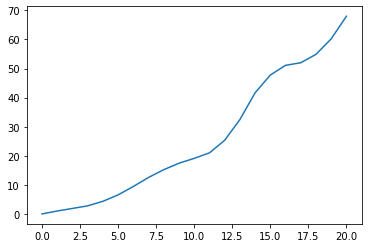

Cumberland County
              State      County  First Doubling  Current Total   Inv Tau  \
442  North Carolina  Cumberland               3             82  0.177749   

          Tau  R Squared  Days In       ID  
442  5.625912   0.986574       20  37051.0  


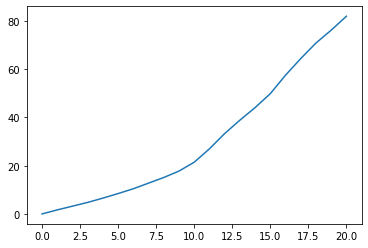

Lee County
              State County  First Doubling  Current Total  Inv Tau  Tau  \
443  North Carolina    Lee              17              8      0.0  0.0   

     R Squared  Days In       ID  
443        0.0       20  37105.0  


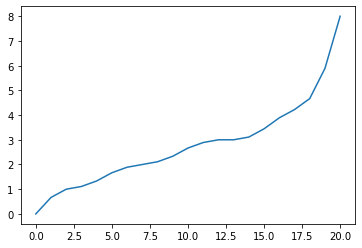

Granville County
              State     County  First Doubling  Current Total   Inv Tau  \
444  North Carolina  Granville               7             88  0.267412   

          Tau  R Squared  Days In       ID  
444  3.739542   0.983824       20  37077.0  


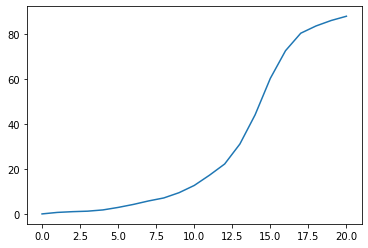

Cherokee County
              State    County  First Doubling  Current Total  Inv Tau  \
445  North Carolina  Cherokee               7             10  0.03183   

           Tau  R Squared  Days In       ID  
445  31.417142   0.801643       20  37039.0  


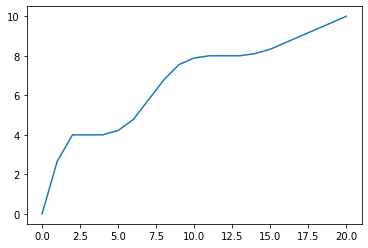

Nash County
              State County  First Doubling  Current Total   Inv Tau       Tau  \
446  North Carolina   Nash               9             32  0.143328  6.977022   

     R Squared  Days In       ID  
446    0.94571       20  37127.0  


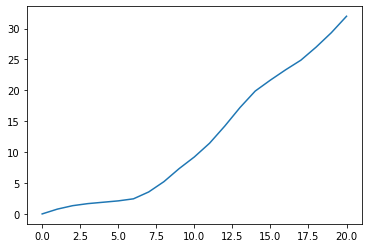

Alamance County
              State    County  First Doubling  Current Total   Inv Tau  \
447  North Carolina  Alamance               4             34  0.148826   

          Tau  R Squared  Days In       ID  
447  6.719234   0.993378       19  37001.0  


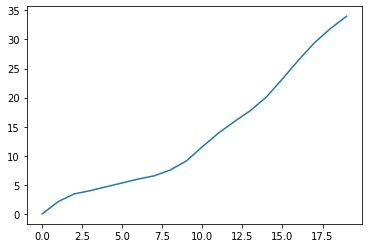

Vance County
              State County  First Doubling  Current Total   Inv Tau       Tau  \
448  North Carolina  Vance              10             19  0.138032  7.244688   

     R Squared  Days In       ID  
448   0.951881       19  37181.0  


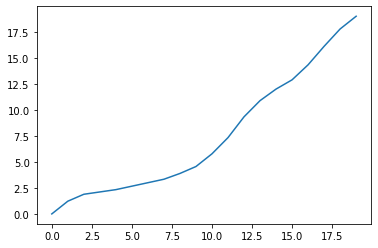

Randolph County
              State    County  First Doubling  Current Total   Inv Tau  \
449  North Carolina  Randolph               3             51  0.127188   

          Tau  R Squared  Days In       ID  
449  7.862388   0.949625       18  37151.0  


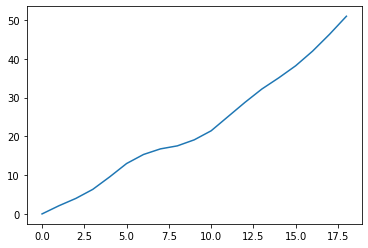

Transylvania County
              State        County  First Doubling  Current Total  Inv Tau  \
450  North Carolina  Transylvania               7              6  0.03172   

           Tau  R Squared  Days In       ID  
450  31.525524   0.930046       18  37175.0  


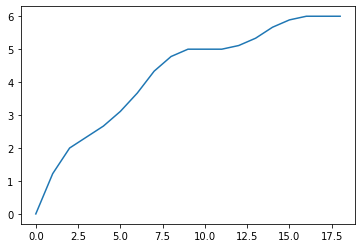

Montgomery County
              State      County  First Doubling  Current Total   Inv Tau  \
451  North Carolina  Montgomery               7             12  0.069732   

           Tau  R Squared  Days In       ID  
451  14.340664   0.923934       18  37123.0  


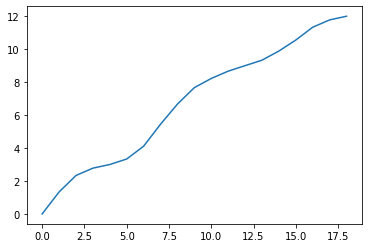

Lenoir County
              State  County  First Doubling  Current Total   Inv Tau  \
452  North Carolina  Lenoir               9             14  0.153542   

          Tau  R Squared  Days In       ID  
452  6.512886   0.984681       17  37107.0  


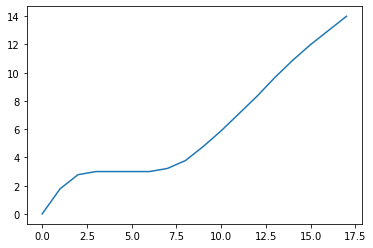

Burke County
              State County  First Doubling  Current Total   Inv Tau       Tau  \
453  North Carolina  Burke               5             61  0.229702  4.353457   

     R Squared  Days In       ID  
453   0.997098       17  37023.0  


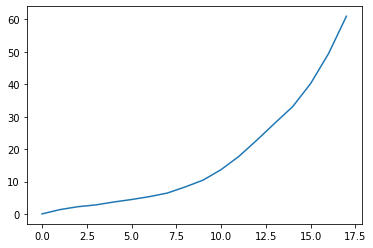

Northampton County
              State       County  First Doubling  Current Total   Inv Tau  \
454  North Carolina  Northampton               4             60  0.088529   

           Tau  R Squared  Days In       ID  
454  11.295789   0.962793       17  37131.0  


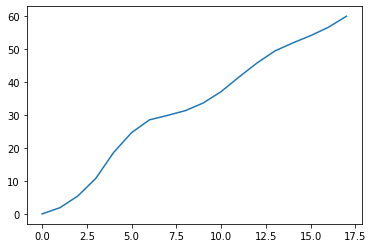

Cleveland County
              State     County  First Doubling  Current Total   Inv Tau  \
455  North Carolina  Cleveland               4             35  0.181843   

          Tau  R Squared  Days In       ID  
455  5.499262   0.992243       17  37045.0  


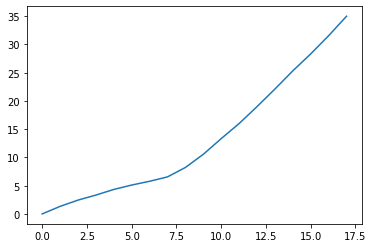

Caldwell County
              State    County  First Doubling  Current Total   Inv Tau  \
456  North Carolina  Caldwell              10             15  0.167185   

          Tau  R Squared  Days In       ID  
456  5.981385   0.960247       17  37027.0  


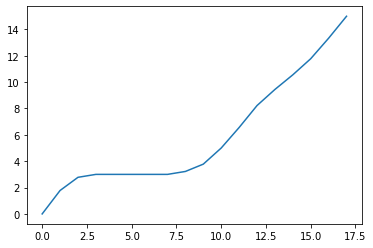

Duplin County
              State  County  First Doubling  Current Total  Inv Tau  Tau  \
457  North Carolina  Duplin              13             15      0.0  0.0   

     R Squared  Days In       ID  
457        0.0       17  37061.0  


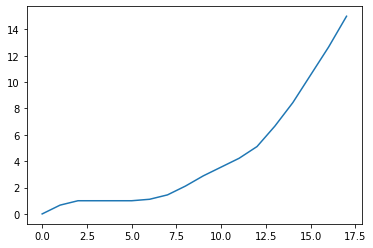

Bertie County
              State  County  First Doubling  Current Total  Inv Tau  \
458  North Carolina  Bertie               5             12  0.07654   

           Tau  R Squared  Days In       ID  
458  13.065099    0.96848       17  37015.0  


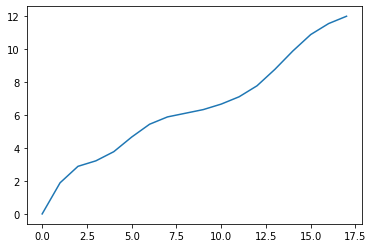

Hertford County
              State    County  First Doubling  Current Total  Inv Tau  Tau  \
459  North Carolina  Hertford              13              4      0.0  0.0   

     R Squared  Days In       ID  
459        0.0       17  37091.0  


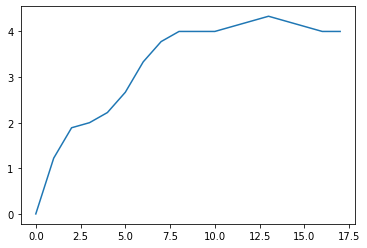

McDowell County
              State    County  First Doubling  Current Total   Inv Tau  \
460  North Carolina  McDowell               6             16  0.073949   

           Tau  R Squared  Days In       ID  
460  13.522813   0.978564       17  37111.0  


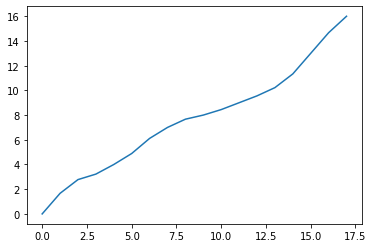

Beaufort County
              State    County  First Doubling  Current Total   Inv Tau  \
461  North Carolina  Beaufort               6             13  0.074598   

           Tau  R Squared  Days In       ID  
461  13.405126    0.94344       16  37013.0  


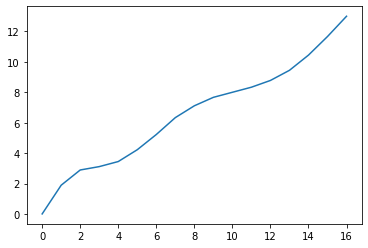

Greene County
              State  County  First Doubling  Current Total   Inv Tau  \
462  North Carolina  Greene               7             10  0.115778   

          Tau  R Squared  Days In       ID  
462  8.637243   0.928637       15  37079.0  


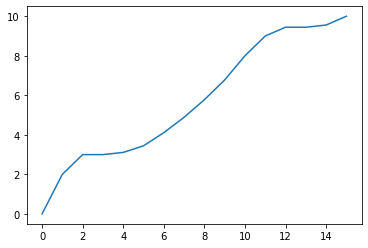

Person County
              State  County  First Doubling  Current Total  Inv Tau      Tau  \
463  North Carolina  Person              10              8  0.10631  9.40645   

     R Squared  Days In       ID  
463   0.952021       15  37145.0  


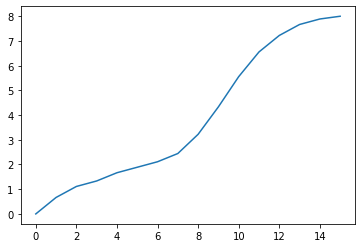

Surry County
              State County  First Doubling  Current Total  Inv Tau  Tau  \
464  North Carolina  Surry              11             10      0.0  0.0   

     R Squared  Days In       ID  
464        0.0       15  37171.0  


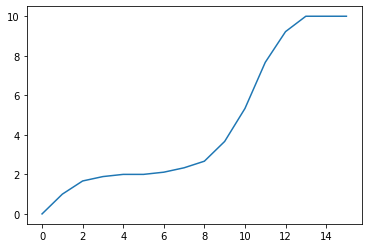

Polk County
              State County  First Doubling  Current Total   Inv Tau  \
465  North Carolina   Polk               6              9  0.070975   

           Tau  R Squared  Days In       ID  
465  14.089538   0.924067       14  37149.0  


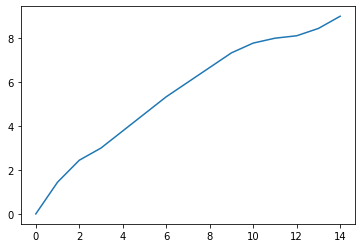

Richmond County
              State    County  First Doubling  Current Total  Inv Tau  Tau  \
466  North Carolina  Richmond              14              7      0.0  0.0   

     R Squared  Days In       ID  
466        0.0       14  37153.0  


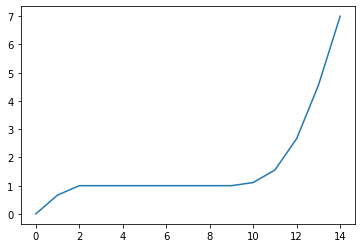

Edgecombe County
              State     County  First Doubling  Current Total  Inv Tau  \
467  North Carolina  Edgecombe               7             22  0.24707   

          Tau  R Squared  Days In       ID  
467  4.047428   0.995329       14  37065.0  


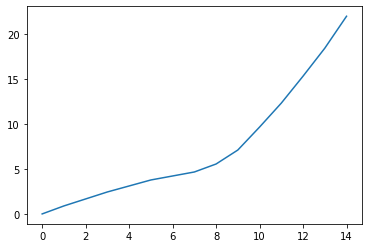

Perquimans County
Empty DataFrame
Columns: [State, County, First Doubling, Current Total, Inv Tau, Tau, R Squared, Days In, ID]
Index: []


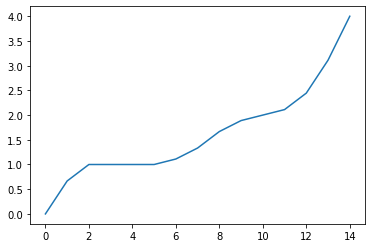

Halifax County
              State   County  First Doubling  Current Total   Inv Tau  \
468  North Carolina  Halifax               4             21  0.120769   

          Tau  R Squared  Days In       ID  
468  8.280255   0.973849       13  37083.0  


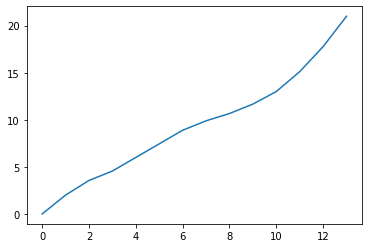

Yadkin County
              State  County  First Doubling  Current Total   Inv Tau  \
469  North Carolina  Yadkin               5             10  0.090434   

           Tau  R Squared  Days In       ID  
469  11.057838   0.820245       13  37197.0  


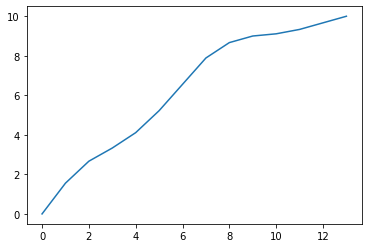

Columbus County
              State    County  First Doubling  Current Total   Inv Tau  \
470  North Carolina  Columbus               7             31  0.227907   

          Tau  R Squared  Days In       ID  
470  4.387753   0.970806       13  37047.0  


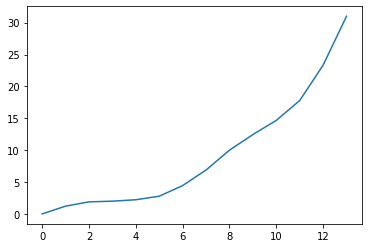

Pamlico County
              State   County  First Doubling  Current Total  Inv Tau  Tau  \
471  North Carolina  Pamlico              13              5      0.0  0.0   

     R Squared  Days In       ID  
471        0.0       13  37137.0  


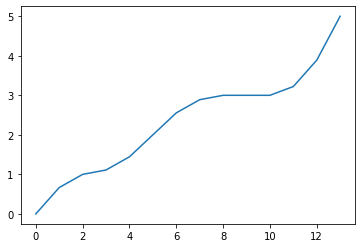

Washington County
              State      County  First Doubling  Current Total   Inv Tau  \
472  North Carolina  Washington               8             15  0.203508   

          Tau  R Squared  Days In       ID  
472  4.913816    0.99981       13  37187.0  


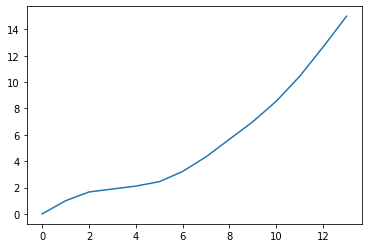

Alleghany County
Empty DataFrame
Columns: [State, County, First Doubling, Current Total, Inv Tau, Tau, R Squared, Days In, ID]
Index: []


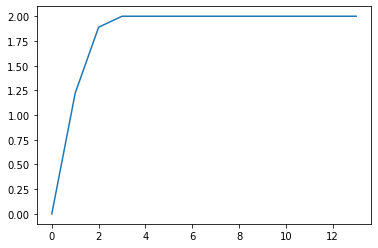

Currituck County
Empty DataFrame
Columns: [State, County, First Doubling, Current Total, Inv Tau, Tau, R Squared, Days In, ID]
Index: []


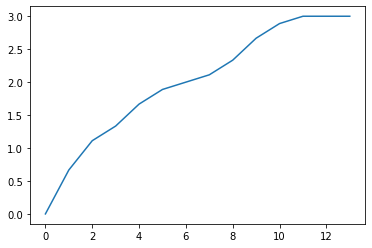

Caswell County
Empty DataFrame
Columns: [State, County, First Doubling, Current Total, Inv Tau, Tau, R Squared, Days In, ID]
Index: []


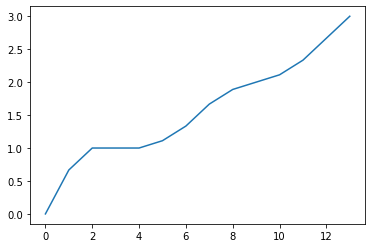

Alexander County
Empty DataFrame
Columns: [State, County, First Doubling, Current Total, Inv Tau, Tau, R Squared, Days In, ID]
Index: []


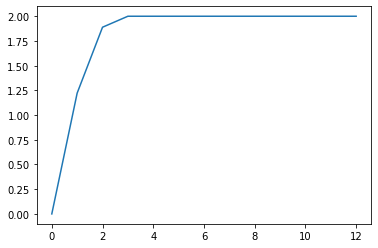

Rutherford County
              State      County  First Doubling  Current Total   Inv Tau  \
473  North Carolina  Rutherford               1             37  0.199774   

          Tau  R Squared  Days In       ID  
473  5.005648   0.958846       12  37161.0  


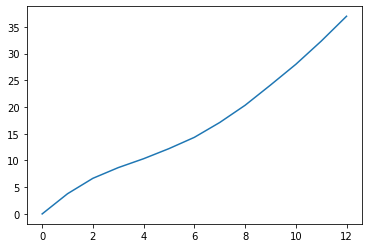

Clay County
Empty DataFrame
Columns: [State, County, First Doubling, Current Total, Inv Tau, Tau, R Squared, Days In, ID]
Index: []


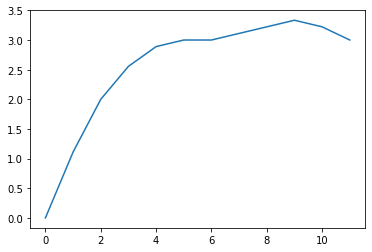

Rockingham County
              State      County  First Doubling  Current Total   Inv Tau  \
474  North Carolina  Rockingham               4             14  0.139693   

          Tau  R Squared  Days In       ID  
474  7.158534   0.983565       11  37157.0  


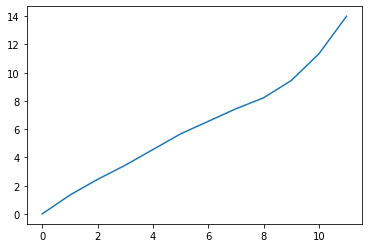

Wilkes County
Empty DataFrame
Columns: [State, County, First Doubling, Current Total, Inv Tau, Tau, R Squared, Days In, ID]
Index: []


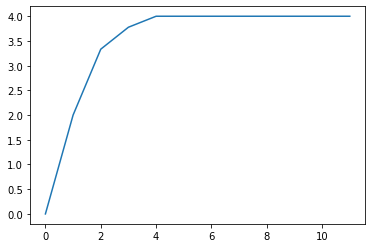

Martin County
              State  County  First Doubling  Current Total  Inv Tau  Tau  \
475  North Carolina  Martin              10              5      0.0  0.0   

     R Squared  Days In       ID  
475        0.0       11  37117.0  


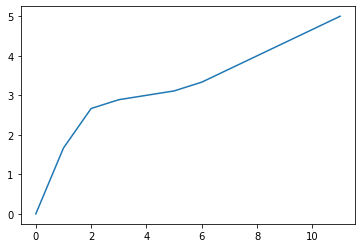

Anson County
              State County  First Doubling  Current Total   Inv Tau       Tau  \
476  North Carolina  Anson               5             10  0.150165  6.659328   

     R Squared  Days In       ID  
476   0.999279       11  37007.0  


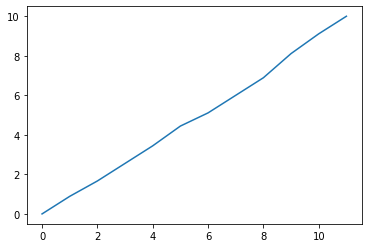

Dare County
              State County  First Doubling  Current Total  Inv Tau  Tau  \
477  North Carolina   Dare               5             10      0.0  0.0   

     R Squared  Days In       ID  
477        0.0        9  37055.0  


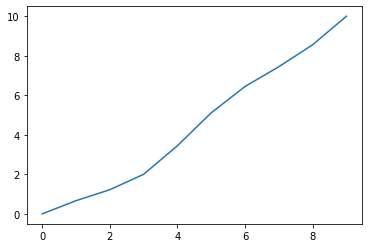

Macon County
Empty DataFrame
Columns: [State, County, First Doubling, Current Total, Inv Tau, Tau, R Squared, Days In, ID]
Index: []


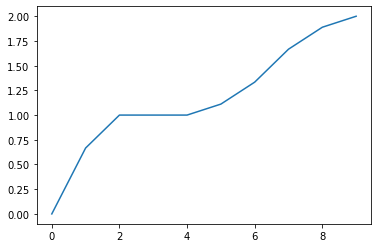

Gates County
Empty DataFrame
Columns: [State, County, First Doubling, Current Total, Inv Tau, Tau, R Squared, Days In, ID]
Index: []


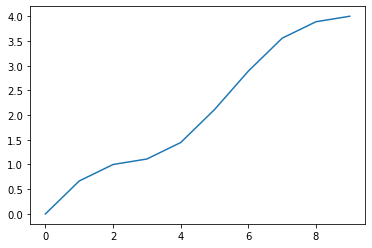

Mitchell County
Empty DataFrame
Columns: [State, County, First Doubling, Current Total, Inv Tau, Tau, R Squared, Days In, ID]
Index: []


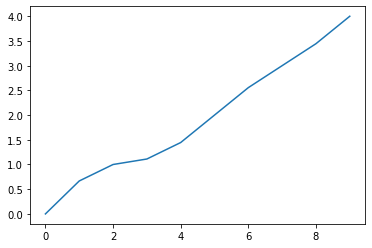

Stokes County
              State  County  First Doubling  Current Total   Inv Tau  \
478  North Carolina  Stokes               2              9  0.100812   

          Tau  R Squared  Days In       ID  
478  9.919501   0.830101        9  37169.0  


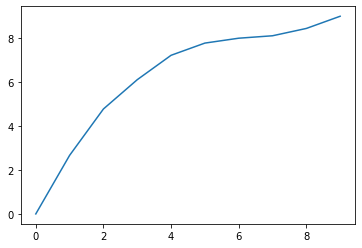

Bladen County
Empty DataFrame
Columns: [State, County, First Doubling, Current Total, Inv Tau, Tau, R Squared, Days In, ID]
Index: []


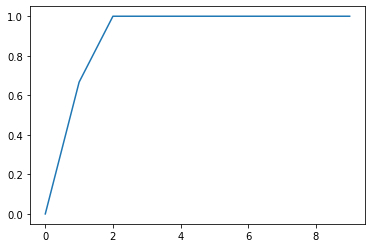

Haywood County
Empty DataFrame
Columns: [State, County, First Doubling, Current Total, Inv Tau, Tau, R Squared, Days In, ID]
Index: []


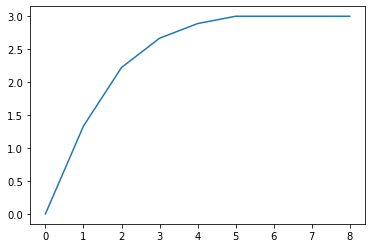

Chowan County
Empty DataFrame
Columns: [State, County, First Doubling, Current Total, Inv Tau, Tau, R Squared, Days In, ID]
Index: []


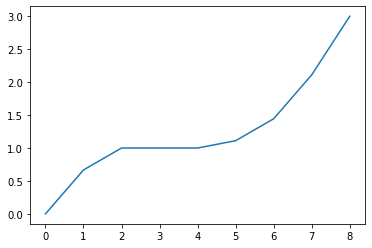

Ashe County
Empty DataFrame
Columns: [State, County, First Doubling, Current Total, Inv Tau, Tau, R Squared, Days In, ID]
Index: []


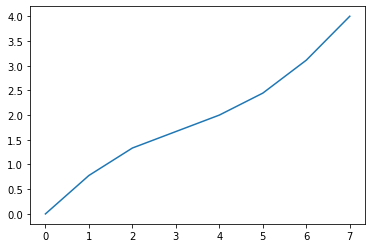

Warren County
Empty DataFrame
Columns: [State, County, First Doubling, Current Total, Inv Tau, Tau, R Squared, Days In, ID]
Index: []


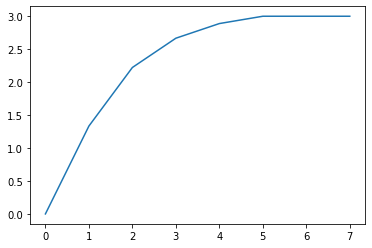

Pender County
              State  County  First Doubling  Current Total  Inv Tau  Tau  \
479  North Carolina  Pender               6              5      0.0  0.0   

     R Squared  Days In       ID  
479        0.0        6  37141.0  


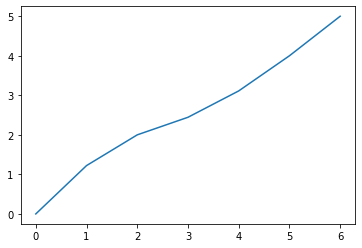

Jackson County
Empty DataFrame
Columns: [State, County, First Doubling, Current Total, Inv Tau, Tau, R Squared, Days In, ID]
Index: []


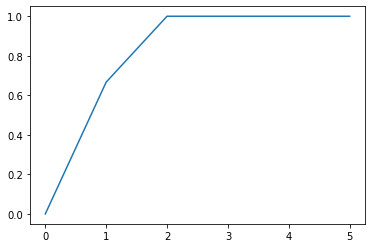

Jones County
              State County  First Doubling  Current Total  Inv Tau  Tau  \
480  North Carolina  Jones               2              6      0.0  0.0   

     R Squared  Days In       ID  
480        0.0        2  37103.0  


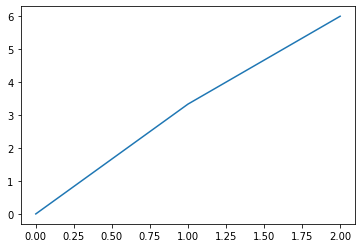

In [51]:
for x in test:
    print(f'{x} County')
    df4 = direct_df.loc[(direct_df['County']==x)&(direct_df['State']==state)]
    print(df4)
    plt.plot(test[x]['xval'],test[x]['casesII'])
    plt.show()

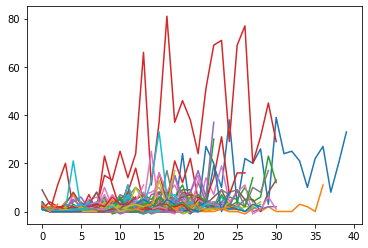

In [52]:
test = exponential[state]
for x in test:
     if len(test[x]['delta']) >2:
            plt.plot(test[x]['xval'],test[x]['delta'])
plt.show()

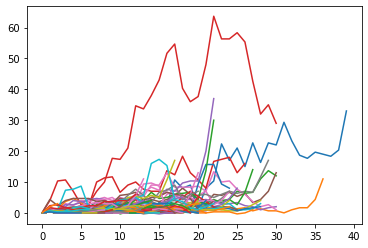

In [53]:
for x in test:
     if len(test[x]['delta']) >2:
            plt.plot(test[x]['xval'],test[x]['deltaI'])
plt.show()

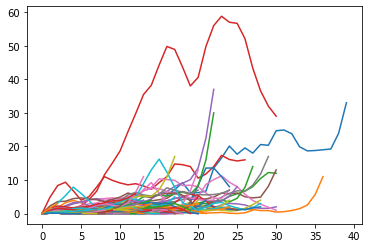

In [54]:
for x in test:
     if len(test[x]['delta']) >2:
            plt.plot(test[x]['xval'],test[x]['deltaII'])
plt.show()

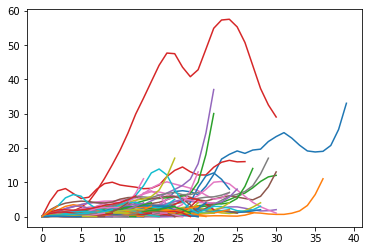

In [55]:
for x in test:
     if len(test[x]['delta']) >2:
            plt.plot(test[x]['xval'],test[x]['deltaIII'])
plt.show()

In [56]:
for x in test:
    print(f'{x} County')
    df4 = deriv_df.loc[(deriv_df['County']==x)&(deriv_df['State']==state)]
    print(df4)
    plt.plot(test[x]['xval'],test[x]['deltaIII'])
    plt.show()


Wake County


NameError: name 'deriv_df' is not defined